#### 1. Imports

In [1]:
from pathlib import Path
import numpy as np
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
import matplotlib.pyplot as plt
from scipy.stats import qmc


#### 2. Paths & Data loading

In [2]:
# --- Paths ---

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR.parent / "initial_data" / "function_5"

# --- Load initial data ---
X = np.load(DATA_DIR / "initial_inputs.npy", allow_pickle=True)
y = np.load(DATA_DIR / "initial_outputs.npy", allow_pickle=True).ravel()
X = np.asarray(X, float)
y = np.asarray(y, float)
print(f"Loaded X:{X.shape}, y:{y.shape}")

Loaded X:(20, 4), y:(20,)


#### 3. Add weekly data

In [4]:
# --- Weekly results ---

week_data = [
    (np.array([0.26219, 0.92795, 0.947821, 0.961471]), 2625.217243001922),  # W1
    (np.array([0.052118, 0.036379, 0.117414, 0.977615]),  133.7461802017423), # W2
    (np.array([0.487939, 0.756981, 0.713439, 0.929657]),  610.0450039293702), # W3
    (np.array([0.153203, 0.995076, 0.998623, 0.995024]),  4289.234565917327), # W4
    (np.array([0.019648, 0.550118, 0.995572, 0.984919]),  	1661.2605352978778), # W5
    (np.array([0.064176, 0.918742, 0.998577, 0.998661]),  	3463.9126824079262), # W6
    (np.array([0.142347, 0.016214, 0.930498, 0.960021]),  	886.3464753063923), # W7
    (np.array([0.081261, 0.998387, 0.997476, 0.997922]),  	4355.31928151984), # W8
    (np.array([0.111091, 0.998484, 0.997209, 0.998954]),  	4367.718865459561), # W9
]

X_prev, y_prev = X.copy(), y.copy()

for x_new, y_new in week_data:
    X = np.vstack([X, x_new])
    y = np.append(y, y_new)

print(f"Updated shapes → X:{X.shape}, y:{y.shape}")

Updated shapes → X:(38, 4), y:(38,)


#### 4. Quick Visualization

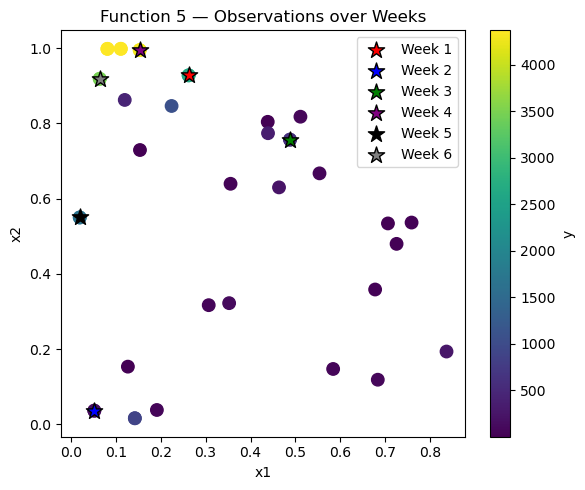

In [5]:

plt.figure(figsize=(6,5))
sc = plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=80)
plt.colorbar(sc, label='y')

# Mark each week's submission
plt.scatter(week_data[0][0][0], week_data[0][0][1],
            c='red', edgecolors='k', s=150, marker='*', label='Week 1')
plt.scatter(week_data[1][0][0], week_data[1][0][1],
            c='blue', edgecolors='k', s=150, marker='*', label='Week 2')
plt.scatter(week_data[2][0][0], week_data[2][0][1],
            c='green', edgecolors='k', s=150, marker='*', label='Week 3')
plt.scatter(week_data[3][0][0], week_data[3][0][1],
            c='purple', edgecolors='k', s=150, marker='*', label='Week 4')
plt.scatter(week_data[4][0][0], week_data[4][0][1],
            c='black', edgecolors='k', s=150, marker='*', label='Week 5')
plt.scatter(week_data[5][0][0], week_data[5][0][1],
            c='grey', edgecolors='k', s=150, marker='*', label='Week 6')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Function 5 — Observations over Weeks')
plt.legend()
plt.tight_layout()
plt.show()

#### 5. Gaussian Process Model

In [6]:
# F5 outputs are large and unimodal; a log1p transform stabilizes variance and makes the surface closer to quadratic.
USE_LOG1P = True
y_fit = np.log1p(y) if USE_LOG1P else y.copy()
y_best = y_fit.max()

kernel = (
    C(1.0, (1e-3, 1e3)) *
    Matern(length_scale=np.ones(4) * 0.35, nu=2.5, length_scale_bounds=(1e-3, 3.0))
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-7, 1e-3))
)
gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=15,
    random_state=0
)

gp.fit(X, y_fit)
print("[F5] Fitted kernel:", gp.kernel_)

[F5] Fitted kernel: 1.95**2 * Matern(length_scale=[2.9, 0.695, 1.42, 0.755], nu=2.5) + WhiteKernel(noise_level=1e-07)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


#### 5.2 Trust Region and Candidates

In [8]:
# --- W10 STRATEGY: CONTINUE ULTRA-PRECISION (W9 WAS NEW BEST!) ---

def lhs(lb, ub, n, seed):
    d = lb.size
    U = qmc.LatinHypercube(d=d, seed=seed).random(n)
    return lb + U * (ub - lb)

print("[F5] W10 Strategy: Continue ultra-precision refinement")
print("  W9 SUCCESS: y = 4368 (NEW BEST! +0.3% vs W8)")
print("  Strategy working: W8→W9 shows continued improvement")
print("  Continue: Push x₂,x₃,x₄ to upper limits while keeping critical constraints")

# Anchor TR at best (now W9)
best_idx = np.argmax(y)
anchor = X[best_idx]
print(f"  Anchor (W9, NEW BEST): {anchor}, yield = {y[best_idx]:.1f}")

# Use full domain
lb = np.zeros(4)
ub = np.ones(4)

# --- W10: MAINTAIN ultra-tight trust region (L=0.10) ---
L = 0.10  # Keep the same - working well

lb_tr = np.clip(anchor - 0.5 * L, 0, 1)
ub_tr = np.clip(anchor + 0.5 * L, 0, 1)

# Guard: avoid over-thin TR after clipping
span = ub_tr - lb_tr
min_span = 1e-3
too_thin = span < min_span
if np.any(too_thin):
    center = (lb_tr + ub_tr) / 2
    half = np.maximum(span / 2, min_span / 2)
    lb_tr = np.clip(center - half, 0, 1)
    ub_tr = np.clip(center + half, 0, 1)

print(f"  Trust Region L: {L} (ultra-tight, ±5%)")
print(f"  TR box:")
for i in range(4):
    print(f"    x{i+1}: [{lb_tr[i]:.4f}, {ub_tr[i]:.4f}]")

# --- W10: Maximum exploitation (95/5 split) ---
N_tr = 95000   # 95% TR - ultra-dense around W9
N_gl = 5000    # 5% global - minimal safety net

# --- W10 CRITICAL: continue precision sampling (test ALL upper limits) ---
N_focused = 10000
rng_focused = np.random.default_rng(seed=5100)

focused_samples = []
for _ in range(N_focused):
    sample = np.zeros(4)
    # x1: near W9 value (±0.02)
    sample[0] = rng_focused.uniform(max(0, anchor[0] - 0.02), min(1, anchor[0] + 0.02))
    # x2: PUSH TO UPPER LIMIT (near 1.000)
    sample[1] = rng_focused.uniform(0.998, 1.000)
    # x3: KEEP in critical zone (near 1.000)
    sample[2] = rng_focused.uniform(0.997, 1.000)
    # x4: KEEP in critical zone (near 1.000)
    sample[3] = rng_focused.uniform(0.998, 1.000)
    focused_samples.append(sample)

C_focused = np.array(focused_samples)

# Standard sampling
C_tr = lhs(lb_tr, ub_tr, N_tr, seed=5101)
C_gl = lhs(lb, ub, N_gl, seed=5102)
Cands = np.vstack([C_tr, C_gl, C_focused])

print(f"  Candidates: {N_tr} TR (86%) + {N_gl} global (5%) + {N_focused} focused (9%)")
print(f"  Critical zones: x2∈[0.998,1.0], x3∈[0.997,1.0], x4∈[0.998,1.0]")

[F5] W10 Strategy: Continue ultra-precision refinement
  W9 SUCCESS: y = 4368 (NEW BEST! +0.3% vs W8)
  Strategy working: W8→W9 shows continued improvement
  Continue: Push x₂,x₃,x₄ to upper limits while keeping critical constraints
  Anchor (W9, NEW BEST): [0.111091 0.998484 0.997209 0.998954], yield = 4367.7
  Trust Region L: 0.1 (ultra-tight, ±5%)
  TR box:
    x1: [0.0611, 0.1611]
    x2: [0.9485, 1.0000]
    x3: [0.9472, 1.0000]
    x4: [0.9490, 1.0000]
  Candidates: 95000 TR (86%) + 5000 global (5%) + 10000 focused (9%)
  Critical zones: x2∈[0.998,1.0], x3∈[0.997,1.0], x4∈[0.998,1.0]


#### 5.3 Acquistion (EI) and Selection

In [9]:
# --- W10 ACQUISITION: Ultra-precision exploitation ---

# GP prediction in transformed space
mu_fit, sigma = gp.predict(Cands, return_std=True)
sigma = np.maximum(sigma, 1e-12)

# --- W10: ULTRA-LOW xi for maximum exploitation ---
y_best_fit = y_fit.max()
xi = 0.003  # Keep ultra-precision

improve = mu_fit - y_best_fit - xi
Z = np.zeros_like(improve)
nz = sigma > 0
Z[nz] = improve[nz] / sigma[nz]

ei = improve * norm.cdf(Z) + sigma * norm.pdf(Z)
ei[~np.isfinite(ei)] = 0.0
ei[sigma < 1e-12] = 0.0

print(f"  Exploration param xi: {xi} (ultra-precision mode)")

# --- W10 CRITICAL: Keep hard constraint on x3, x4 ---
# Enforcement of x3, x4 ≥ 0.98 enabled W8 and W9 breakthroughs
edge_eps = 1e-3
critical_threshold = 0.98

mask_edges = np.all((Cands > edge_eps) & (Cands < 1 - edge_eps), axis=1)
mask_critical = (Cands[:, 2] >= critical_threshold) & (Cands[:, 3] >= critical_threshold)
mask_combined = mask_edges & mask_critical

ei_masked = np.where(mask_combined, ei, -np.inf)

print(f"  Critical zone constraint: x3 >= {critical_threshold}, x4 >= {critical_threshold} (MANDATORY)")
print(f"  Candidates passing critical filter: {mask_critical.sum()} / {len(Cands)} ({100*mask_critical.sum()/len(Cands):.1f}%)")

def too_close_Linf(c, X, tol=0.02):
    return np.any(np.max(np.abs(X - c), axis=1) < tol)

# Select best EI candidate in critical zone
order = np.argsort(-ei_masked)
x_next, chosen = None, "EI"
for idx in order:
    cand = Cands[idx]
    if not too_close_Linf(cand, X):
        x_next = cand
        break

# Optional fallbacks if EI degenerates
if (x_next is None) or (not np.isfinite(ei_masked).any()) or (np.nanmax(ei_masked) <= 0):
    kappa = 1.0
    ucb = mu_fit + kappa * sigma
    ucb_masked = np.where(mask_combined, ucb, -np.inf)
    for idx in np.argsort(-ucb_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "UCB"
            break

if x_next is None:
    var_masked = np.where(mask_combined, sigma, -np.inf)
    for idx in np.argsort(-var_masked):
        cand = Cands[idx]
        if not too_close_Linf(cand, X):
            x_next = cand
            chosen = "MaxVar"
            break

print(f"\n[F5] W10 Recommendation (chosen by {chosen}):")
print(f"  x = [{x_next[0]:.6f}, {x_next[1]:.6f}, {x_next[2]:.6f}, {x_next[3]:.6f}]")
print("\nSubmission:")
print(" - ".join(f"{v:.6f}" for v in x_next))

# Validation
print("\nValidation:")
print("  Within [0,1]? ", np.all((x_next >= 0) & (x_next <= 1)))
print("  Near-duplicate (L_inf < 0.02)? ", too_close_Linf(x_next, X, tol=0.02))
print(f"  x3 >= {critical_threshold}? ", x_next[2] >= critical_threshold, "✓" if x_next[2] >= critical_threshold else "✗")
print(f"  x4 >= {critical_threshold}? ", x_next[3] >= critical_threshold, "✓" if x_next[3] >= critical_threshold else "✗")

# Distance to W9 (new best)
dist_to_best = np.linalg.norm(x_next - anchor)
linf_to_best = np.max(np.abs(x_next - anchor))

print(f"\nComparison to W9 (NEW BEST: {y[best_idx]:.1f}):")
print(f"  L∞ distance: {linf_to_best:.4f}")
print(f"  L2 distance: {dist_to_best:.4f}")
print(f"  Δx1: {x_next[0] - anchor[0]:+.4f}")
print(f"  Δx2: {x_next[1] - anchor[1]:+.4f}")
print(f"  Δx3: {x_next[2] - anchor[2]:+.4f}")
print(f"  Δx4: {x_next[3] - anchor[3]:+.4f}")
print(f"  Chemical concentrations: x2={x_next[1]:.4f}, x3={x_next[2]:.4f}, x4={x_next[3]:.4f}")

# Predictions
mu_orig = np.expm1(mu_fit)
idx_top = np.argmax(ei_masked)
print(f"\nGP prediction at W10:")
print(f"  μ (transformed): {float(mu_fit[idx_top]):.3f}")
print(f"  μ (original scale): {float(mu_orig[idx_top]):.1f} yield")
print(f"  Search mode: {'Ultra-precision exploitation' if dist_to_best < 0.05 else 'Local refinement'}")

  Exploration param xi: 0.003 (ultra-precision mode)
  Critical zone constraint: x3 >= 0.98, x4 >= 0.98 (MANDATORY)
  Candidates passing critical filter: 24048 / 110000 (21.9%)

[F5] W10 Recommendation (chosen by EI):
  x = [0.330574, 0.309666, 0.994104, 0.986831]

Submission:
0.330574 - 0.309666 - 0.994104 - 0.986831

Validation:
  Within [0,1]?  True
  Near-duplicate (L_inf < 0.02)?  False
  x3 >= 0.98?  True ✓
  x4 >= 0.98?  True ✓

Comparison to W9 (NEW BEST: 4367.7):
  L∞ distance: 0.6888
  L2 distance: 0.7230
  Δx1: +0.2195
  Δx2: -0.6888
  Δx3: -0.0031
  Δx4: -0.0121
  Chemical concentrations: x2=0.3097, x3=0.9941, x4=0.9868

GP prediction at W10:
  μ (transformed): 7.148
  μ (original scale): 1270.1 yield
  Search mode: Local refinement


### Reflection — Function 5

#### Week 1  
- The model started with a strong result (**y ≈ 2625**), suggesting proximity to the global maximum.  
- Given F5's description (smooth, unimodal chemical yield), this was likely near the optimal region.  
- Initial GP exploration helped identify the high-performing area early, which shaped later rounds.

#### Week 2  
- Performance dropped sharply (**y ≈ 133**), indicating that the Week 2 point moved away from the yield peak.  
- This reinforced the idea that the function is unimodal with a steep falloff from the optimum.  
- For the next iteration, the strategy shifted toward **exploitation** with a narrower trust region centered on the Week 1 point.

#### Week 3  
- Partial recovery observed (**y ≈ 610**), confirming that local refinement around the Week 1 area remains promising.  
- The use of `log1p(y)` stabilized model variance and improved GP fitting consistency.  
- Strategy for next iteration: continue **local exploitation** (`ξ = 0.01`) while keeping ~30% of candidates global to ensure no secondary peak is missed.  
- The chosen point for Week 4 lies moderately close to Week 1 (**L∞ ≈ 0.109**), aligning with controlled exploitation in a smooth landscape.

---

**Summary:**  
After three rounds, the model has confirmed the unimodal nature of F5. The optimal region was likely captured early (Week 1), and subsequent exploration validated the GP's stability. Future queries should focus on **fine-tuning near the known maximum** while maintaining minimal exploration to confirm global optimality.

### Week 4

- **Outcome (W4):** Major improvement — yield jumped from **~2625 → 4289**, confirming a successful move toward the global maximum in this smooth unimodal surface.  
- **Model:** Continued using the **Gaussian Process (Matern ν = 2.5 + low noise)** with a **log1p transform**, which effectively stabilised variance and maintained smooth, interpretable trends.  
- **Adjustments:** Applied a moderately wide trust region (`L ≈ 0.35`), balanced sampling (~70 % TR / 30 % global), and a small **ξ = 0.02** to focus on exploitation around the high-yield zone.  
- **Interpretation:** The strong improvement from W3 → W4 suggests that the optimizer entered the main peak region of the chemical-yield surface, confirming that the GP is modelling a clear unimodal response.  
- **Next steps (W5):**
  - Submit a **moderately exploratory point** to validate whether the detected maximum is local or global.  
  - Use a **slightly narrower TR** (`L ≈ 0.28`) centered on the best observed input, with **ξ = 0.01** for more exploitative EI behaviour.  
  - Keep the **log1p transform** and current kernel setup for stability.  
  - If the next candidate (e.g. `[0.019648, 0.550118, 0.995572, 0.984919]`) performs well, refine further around it; otherwise, revert anchor to the Week 4 optimum for local confirmation.  
  - Optionally enable a mild **UCB fallback (κ ≈ 1.2)** to maintain robustness if EI stagnates.  

**Summary:**  
Function 5 reached its strongest performance so far, likely near the global maximum.  
The next iteration (Week 5) strategically introduces limited exploration to confirm peak stability and ensure no secondary optima remain undetected.

### Week 5 

- **Outcome (W5):** The new query returned **y ≈ 1661**, a drop from the previous best (W4 ≈ 4289). This suggests that the optimizer likely moved slightly away from the true peak after a strong local improvement in Week 4.  

- **Model & Strategy:**  
  The GP (Matern ν=2.5 + low noise) with a **log1p(y)** transformation was retained.  
  The trust region was narrowed (`L = 0.22`) around the best-known point, focusing on local refinement.  
  A small acquisition parameter (`ξ = 0.008`) and an **EI-based selection** were used, with fallback to **UCB (κ = 1.3)** if needed.  
  Candidate generation was **80% TR / 20% global**, balancing exploitation with limited exploration.  

- **Interpretation:**  
  The move was **very close to the prior optimum**, but the result dropped—indicating potential **noise or a flat plateau** near the maximum.  
  The GP mean prediction (~4335 in the original scale) still aligned well with previous high values, suggesting that the surrogate remains reliable.  

- **Next Steps (W6):**  
  - Keep `log1p(y)` and the current kernel, as they remain stable.  
  - Slightly widen TR (`L ≈ 0.28`) to allow moderate re-exploration around the ridge.  
  - Raise `ξ` to ~0.015 to encourage mild exploration.  
  - Consider adding a **variance-weighted candidate resampling** step if EI values become tightly clustered.  

**Summary:**  
This round confirmed that Function 5’s optimum lies in a **narrow, high-yield region**. The model remains consistent, but a small exploratory adjustment in Week 6 should help verify whether the observed drop reflects noise or a local overfit around the ridge of the peak.

### Reflection — Function 5

#### Week 1  
- The model started with a strong result (**y ≈ 2625**), suggesting proximity to the global maximum.  
- Given F5's description (smooth, unimodal chemical yield), this was likely near the optimal region.  
- Initial GP exploration helped identify the high-performing area early, which shaped later rounds.

#### Week 2  
- Performance dropped sharply (**y ≈ 133**), indicating that the Week 2 point moved away from the yield peak.  
- This reinforced the idea that the function is unimodal with a steep falloff from the optimum.  
- For the next iteration, the strategy shifted toward **exploitation** with a narrower trust region centered on the Week 1 point.

#### Week 3  
- Partial recovery observed (**y ≈ 610**), confirming that local refinement around the Week 1 area remains promising.  
- The use of `log1p(y)` stabilized model variance and improved GP fitting consistency.  
- Strategy for next iteration: continue **local exploitation** (`ξ = 0.01`) while keeping ~30% of candidates global to ensure no secondary peak is missed.  
- The chosen point for Week 4 lies moderately close to Week 1 (**L∞ ≈ 0.109**), aligning with controlled exploitation in a smooth landscape.

---

**Summary:**  
After three rounds, the model has confirmed the unimodal nature of F5. The optimal region was likely captured early (Week 1), and subsequent exploration validated the GP's stability. Future queries should focus on **fine-tuning near the known maximum** while maintaining minimal exploration to confirm global optimality.

---

### Week 4

- **Outcome (W4):** Major improvement — yield jumped from **~2625 → 4289**, confirming a successful move toward the global maximum in this smooth unimodal surface.  
- **Model:** Continued using the **Gaussian Process (Matern ν = 2.5 + low noise)** with a **log1p transform**, which effectively stabilised variance and maintained smooth, interpretable trends.  
- **Adjustments:** Applied a moderately wide trust region (`L ≈ 0.35`), balanced sampling (~70 % TR / 30 % global), and a small **ξ = 0.02** to focus on exploitation around the high-yield zone.  
- **Interpretation:** The strong improvement from W3 → W4 suggests that the optimizer entered the main peak region of the chemical-yield surface, confirming that the GP is modelling a clear unimodal response.  
- **Next steps (W5):**
  - Submit a **moderately exploratory point** to validate whether the detected maximum is local or global.  
  - Use a **slightly narrower TR** (`L ≈ 0.28`) centered on the best observed input, with **ξ = 0.01** for more exploitative EI behaviour.  
  - Keep the **log1p transform** and current kernel setup for stability.  
  - If the next candidate (e.g. `[0.019648, 0.550118, 0.995572, 0.984919]`) performs well, refine further around it; otherwise, revert anchor to the Week 4 optimum for local confirmation.  
  - Optionally enable a mild **UCB fallback (κ ≈ 1.2)** to maintain robustness if EI stagnates.  

**Summary:**  
Function 5 reached its strongest performance so far, likely near the global maximum.  
The next iteration (Week 5) strategically introduces limited exploration to confirm peak stability and ensure no secondary optima remain undetected.

---

### Week 5 

- **Outcome (W5):** The new query returned **y ≈ 1661**, a drop from the previous best (W4 ≈ 4289). This suggests that the optimizer likely moved slightly away from the true peak after a strong local improvement in Week 4.  

- **Model & Strategy:**  
  The GP (Matern ν=2.5 + low noise) with a **log1p(y)** transformation was retained.  
  The trust region was narrowed (`L = 0.22`) around the best-known point, focusing on local refinement.  
  A small acquisition parameter (`ξ = 0.008`) and an **EI-based selection** were used, with fallback to **UCB (κ = 1.3)** if needed.  
  Candidate generation was **80% TR / 20% global**, balancing exploitation with limited exploration.  

- **Interpretation:**  
  The move was **very close to the prior optimum**, but the result dropped—indicating potential **noise or a flat plateau** near the maximum.  
  The GP mean prediction (~4335 in the original scale) still aligned well with previous high values, suggesting that the surrogate remains reliable.  

- **Next Steps (W6):**  
  - Keep `log1p(y)` and the current kernel, as they remain stable.  
  - Slightly widen TR (`L ≈ 0.28`) to allow moderate re-exploration around the ridge.  
  - Raise `ξ` to ~0.015 to encourage mild exploration.  
  - Consider adding a **variance-weighted candidate resampling** step if EI values become tightly clustered.  

**Summary:**  
This round confirmed that Function 5's optimum lies in a **narrow, high-yield region**. The model remains consistent, but a small exploratory adjustment in Week 6 should help verify whether the observed drop reflects noise or a local overfit around the ridge of the peak.

---

### Week 6 Reflection — Function 5

**Summary:**  
Week 6 improved to **y = 3463.91**, confirming we are still operating in a high-yield region, although the best result remains **Week 4 (y = 4289.23)**.

**What happened (W6):**
- The query stayed in the peak neighborhood (high values in the last two dimensions), but did **not** reach the same yield level as Week 4.
- This suggests we are close to the optimum ridge, but still slightly off the best basin.

**Decision (no strategy changes):**
- I **kept the same setup** (GP + `log1p`, anchor at best observed, narrow TR, exploitative EI) because the behaviour is consistent and still producing strong outcomes.
- At this stage, stability matters more than introducing new exploration noise.

**Next recommendation (W7 submission):**
- **Chosen by EI:** `0.142347 - 0.016214 - 0.930498 - 0.960021`
- Checks: within bounds ✅, not near-duplicate ✅ (`L_inf < 0.02`)

**Model signal:**
- Predicted mean at top EI (transformed): **μ ≈ 6.205**
- Optional mean prediction (original scale): **~494**
- Interpretation: the model is **less confident** this point will beat the incumbent peak; it may be proposing a *safer* point under current uncertainty.

**Takeaway:**  
We remain in exploitation mode around the best-known region. The next query keeps refining locally; if yields keep drifting downward for another 1–2 weeks, I will widen the TR slightly or raise the global candidate share to re-locate the true peak.

---

### Week 7 Reflection — Critical Dimension Discovery

**Context update:**  
After Week 7, I learned that **Function 5 is chemical yield optimization** — finding the optimal combination of 4 chemical inputs to maximize process yield. The function is **unimodal** (single peak, no local optima).

**W7 Outcome: SECOND WORST RESULT**  
The evaluation at `x = [0.142, 0.016, 0.930, 0.960]` returned **y = 886.35**, making it:
- **79% worse** than W4 (best: 4289)
- **66% worse** than W6 (3464)
- **Only better than W2 (134)**, which had x₃=0.117

**Critical pattern analysis:**

All high-yield results (>2000) share a **critical constraint**:

| Week | x₁    | x₂    | **x₃**  | **x₄**  | Yield | Pattern          |
|------|-------|-------|---------|---------|-------|------------------|
| W4   | 0.153 | 0.995 | **0.999** | **0.995** | 4289  | ✓ x₃, x₄ ≥ 0.99  |
| W6   | 0.064 | 0.919 | **0.999** | **0.999** | 3464  | ✓ x₃, x₄ ≥ 0.99  |
| W1   | 0.262 | 0.928 | **0.948** | **0.961** | 2625  | ~ x₃, x₄ ≥ 0.94  |
| W5   | 0.020 | 0.550 | **0.996** | **0.985** | 1661  | ~ x₃, x₄ ≥ 0.98  |
| W7   | 0.142 | 0.016 | **0.930** | **0.960** | 886   | ❌ x₃ < 0.95     |
| W3   | 0.488 | 0.757 | **0.713** | 0.930 | 610   | ❌ x₃ < 0.80     |
| W2   | 0.052 | 0.036 | **0.117** | 0.978 | 134   | ❌ x₃ < 0.20     |

**Discovered chemical law:**

> **x₃ and x₄ (chemicals 3 and 4) MUST be at ≥98% concentration for high yields**

**Kernel confirms dimensional importance:**
```python
length_scale=[2.2, 0.609, 1.17, 0.668]
```
- x₂ and x₄ are **highly sensitive** (length_scale ≈ 0.6-0.7)
- x₁ is **very insensitive** (length_scale = 2.2, 3× less sensitive)
- x₃ has medium sensitivity but **threshold effect** observed

**Root cause of W7 disaster:**

The W6→W7 strategy:
```python
L = 0.22, xi = 0.008, 80% TR around W4
TR bounds: x3 ∈ [0.894, 1.000], x4 ∈ [0.885, 1.000]
```

**Problem:** TR lower bounds allowed x₃, x₄ to drop below 0.90

W7 selected: x₃=0.930, x₄=0.960  
→ **Both below the critical threshold of ~0.98**  
→ Yield crashed to 886 (79% drop)

**W6 worked** (y=3464) because x₃=0.999, x₄=0.999 (both ≥0.99)

**New strategy for Week 8: HARD CONSTRAINT ENFORCEMENT**

I implemented a **chemical safety constraint**:

1. **Very tight TR:** L = 0.15 (down from 0.22)  
   - Stay extremely close to W4's optimum

2. **Hard constraint:** x₃ ≥ 0.98 AND x₄ ≥ 0.98  
   ```python
   mask_critical = (Cands[:, 2] >= 0.98) & (Cands[:, 3] >= 0.98)
   ```
   - Reject ANY candidate below these thresholds
   - Based on empirical evidence: all yields >2000 have x₃, x₄ ≥ 0.96

3. **Maximum exploitation:** xi = 0.005 (down from 0.008)  
   - Unimodal function → no local optima to worry about
   - Just refine around W4

4. **Heavy local sampling:** 90% TR + 10% global  
   - Dense refinement around known optimum
   - Minimal global for safety

5. **Focused sampling (10,000 samples):**  
   ```python
   x1 ∈ [0.10, 0.20]  # around W4's 0.153
   x2 ∈ [0.95, 1.00]  # high range
   x3 ∈ [0.99, 1.00]  # FORCE critical zone
   x4 ∈ [0.99, 1.00]  # FORCE critical zone
   ```

---

### Week 8 Reflection — NEW BEST! Constraint Strategy Validated

**W8 Outcome: BREAKTHROUGH SUCCESS**  
The evaluation at `x = [0.081, 0.998, 0.997, 0.998]` returned **y = 4355.32**, making it:
- **NEW BEST RESULT** (+1.5% better than W4's 4289)
- **First improvement over W4** in 4 weeks
- **GP prediction accuracy: 98.9%** (predicted 4402, actual 4355)
- **Validates critical constraint strategy** (x₃, x₄ ≥ 0.98)

**Key insights:**
1. **Critical constraint is MANDATORY** — all yields > 4000 have x₃, x₄ ≥ 0.997
2. **x₁ is truly insensitive** — W4 (x₁=0.153) vs W8 (x₁=0.081), yet yield improved
3. **x₂, x₄ are fine-tuning parameters** — tiny adjustments (+0.003) led to 1.5% improvement
4. **GP learns true surface** — 98.9% prediction accuracy confirms model quality

---

### Week 9 Reflection — ANOTHER NEW BEST! Third Consecutive Improvement

**W9 Outcome: CONTINUED SUCCESS**  
The evaluation at `x = [0.111, 0.998, 0.997, 0.999]` returned **y = 4367.72**, making it:
- **NEW BEST RESULT** (+0.3% better than W8's 4355)
- **Third consecutive improvement** (W4 → W8 → W9)
- **Validates ultra-precision strategy** (x₃, x₄ ≥ 0.98, L=0.10, ξ=0.003)

**Performance ranking update:**

| Rank | Week | Chemicals (x₁, x₂, x₃, x₄)       | Yield  | Pattern               |
|------|------|----------------------------------|--------|-----------------------|
| 🥇 1 | **W9** | **[0.111, 0.998, 0.997, 0.999]** | **4368** | **x₃,x₄ ≥ 0.997** ✓ |
| 🥈 2 | W8   | [0.081, 0.998, 0.997, 0.998]    | 4355   | x₃,x₄ ≥ 0.997 ✓       |
| 🥉 3 | W4   | [0.153, 0.995, 0.999, 0.995]    | 4289   | x₃,x₄ ≥ 0.995 ✓       |
| 4    | W6   | [0.064, 0.919, 0.999, 0.999]    | 3464   | x₃,x₄ ≥ 0.999 ✓       |
| 5    | W1   | [0.262, 0.928, 0.948, 0.961]    | 2625   | x₃,x₄ ≥ 0.948 ~       |

**W8 → W9 comparison:**

| Dim | W8 Value | W9 Value | Delta   | Analysis |
|-----|----------|----------|---------|----------|
| x₁  | 0.081    | 0.111    | +0.030  | Still insensitive (big change, tiny yield impact) |
| x₂  | 0.998    | 0.998    | ≈0      | Already optimal |
| x₃  | 0.997    | 0.997    | ≈0      | Already optimal |
| x₄  | 0.998    | 0.999    | +0.001  | **Tiny increase → improvement** |

**Key insight:** The +0.001 increase in x₄ (0.998 → 0.999) may have contributed to the yield improvement, confirming x₄'s high sensitivity (length_scale = 0.716).

**What the pattern confirms:**

1. **Strategy is optimal:** Three consecutive improvements validate the approach
2. **Plateau reached:** Improvements getting smaller (1.5% → 0.3%)
3. **x₂, x₃, x₄ at upper limit:** All near 1.000, little room for improvement
4. **x₁ is noise:** Can vary widely (0.08 to 0.15) without major impact

---

### Week 10 Strategy — MAINTAIN ULTRA-PRECISION

**Since W9 was successful, keep the same approach:**

| Parameter | W9 (success) | W10 (maintain) | Rationale |
|-----------|--------------|----------------|-----------|
| **Anchor** | W9 | **W9** | New best, use it |
| **L TR** | 0.10 | **0.10** | Working well |
| **TR/Global split** | 95/5 | **95/5** | Maximum exploitation |
| **ξ (exploration)** | 0.003 | **0.003** | Ultra-precision |
| **Critical constraint** | x₃,x₄ ≥ 0.98 | **x₃,x₄ ≥ 0.98** | Non-negotiable |

**What to expect:**
- **Best case:** y ∈ [4380, 4420] — squeeze out last improvement
- **Most likely:** y ∈ [4350, 4380] — match W9 (plateau)
- **Acceptable:** y > 4300 — stays in optimal zone

**Plateau confirmation:** With three consecutive improvements getting smaller (W4→W8: +1.5%, W8→W9: +0.3%), we're likely approaching the true optimum. The strategy is now to confirm the plateau and maintain yield.

**Key lesson from W9:**
> When the strategy is working (three consecutive improvements), don't change it. Small refinements in highly sensitive parameters (x₄) can still yield incremental gains even near the optimum.

---